In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from PIL import Image

import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import time


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

valid_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [4]:
train_dir = "archive-intel/seg_train/seg_train"
valid_dir = "archive-intel/seg_test/seg_test"
pred_dir = "archive-intel/seg_pred/seg_pred"

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=4)

classes = train_data.classes
num_classes = len(classes)
num_classes

print(f"Number of classes: {num_classes}")


Number of classes: 6


In [5]:
model = timm.create_model(
    "tf_efficientnet_b0",
    pretrained=True,
    num_classes=num_classes
)

model.to(device)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=15,
    eta_min=1e-6
)


In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item()


In [8]:
def train_model(model, epochs=10):
    best_acc = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        t0 = time.time()

        # TRAIN
        model.train()
        train_loss = 0
        train_acc = 0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * X.size(0)
            train_acc += accuracy(outputs, y)
            total += y.size(0)

        train_loss /= total
        train_acc /= total

        # VALIDATION
        model.eval()
        val_loss = 0
        val_acc = 0
        val_total = 0

        with torch.no_grad():
            for X, y in valid_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)

                val_loss += loss.item() * X.size(0)
                val_acc += accuracy(outputs, y)
                val_total += y.size(0)

        val_loss /= val_total
        val_acc /= val_total

        scheduler.step()

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_efficientnet_b0.pth")

        print(f"Epoch {epoch}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")
        print(f"Time: {time.time()-t0:.2f}s")
        print("-"*40)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    return history

history = train_model(model, epochs=15)


Epoch 1/15
Train Loss: 0.4867, Train Acc: 0.8291
Val Loss:   0.2826, Val Acc:   0.8957
Time: 86.05s
----------------------------------------
Epoch 2/15
Train Loss: 0.2837, Train Acc: 0.8976
Val Loss:   0.1971, Val Acc:   0.9267
Time: 85.51s
----------------------------------------
Epoch 3/15
Train Loss: 0.2380, Train Acc: 0.9128
Val Loss:   0.2333, Val Acc:   0.9130
Time: 85.29s
----------------------------------------
Epoch 4/15
Train Loss: 0.2121, Train Acc: 0.9238
Val Loss:   0.2110, Val Acc:   0.9273
Time: 85.45s
----------------------------------------
Epoch 5/15
Train Loss: 0.1911, Train Acc: 0.9316
Val Loss:   0.2138, Val Acc:   0.9250
Time: 100.60s
----------------------------------------
Epoch 6/15
Train Loss: 0.1549, Train Acc: 0.9438
Val Loss:   0.1831, Val Acc:   0.9377
Time: 112.69s
----------------------------------------
Epoch 7/15
Train Loss: 0.1404, Train Acc: 0.9494
Val Loss:   0.2088, Val Acc:   0.9257
Time: 114.14s
----------------------------------------
Epoch 8/15

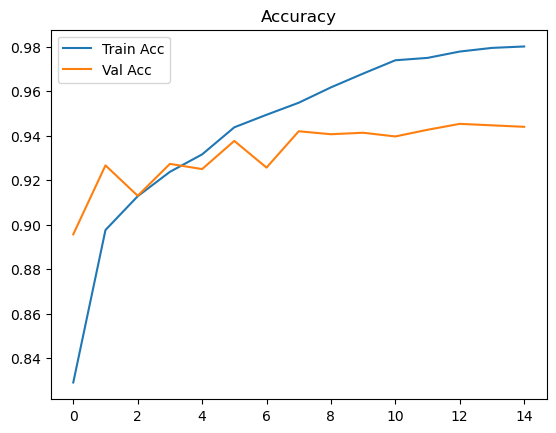

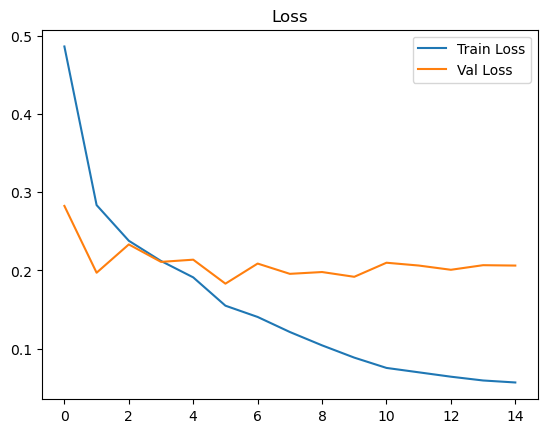

In [9]:
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend(); plt.title("Accuracy"); plt.show()

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss"); plt.show()


In [10]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for X, y in valid_loader:
        X = X.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.numpy())

print(classification_report(all_targets, all_preds, target_names=classes))


              precision    recall  f1-score   support

   buildings       0.96      0.93      0.94       437
      forest       0.99      0.99      0.99       474
     glacier       0.92      0.89      0.91       553
    mountain       0.90      0.92      0.91       525
         sea       0.97      0.98      0.97       510
      street       0.94      0.96      0.95       501

    accuracy                           0.94      3000
   macro avg       0.95      0.94      0.95      3000
weighted avg       0.94      0.94      0.94      3000



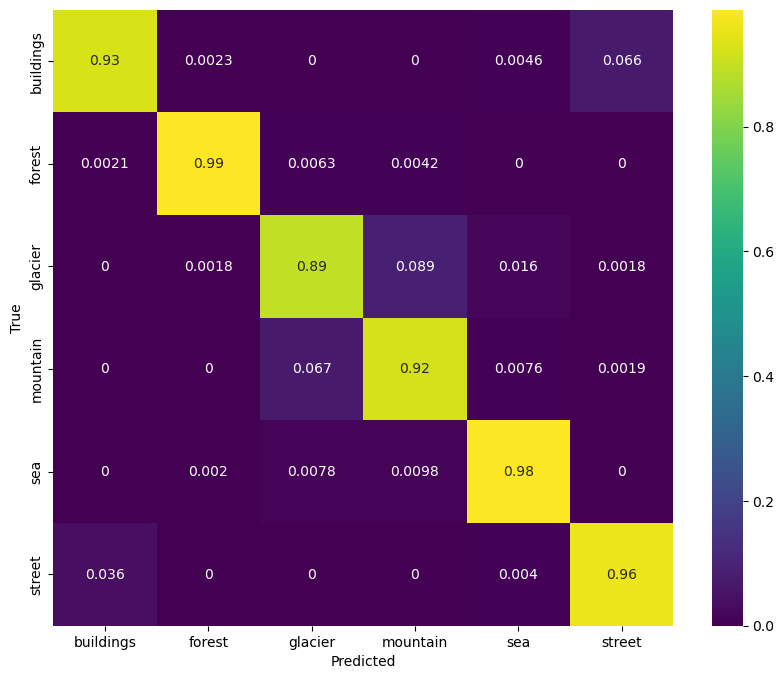

In [11]:
cm = confusion_matrix(all_targets, all_preds, normalize="true")

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap="viridis",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [29]:
import pandas as pd

image_paths = []
true_indices = []
true_labels = []
pred_indices = []
pred_labels = []
pred_confidences = []

model.eval()

with torch.no_grad():
    for paths, labels in valid_data.samples:   # valid_data is ImageFolder
        img = Image.open(paths).convert("RGB")

        # Apply validation transform
        t = valid_transform(img).unsqueeze(0).to(device)

        # Forward pass
        logits = model(t)
        probs = torch.softmax(logits, dim=1)

        pred_idx = probs.argmax(1).item()
        conf = probs[0][pred_idx].item()

        image_paths.append(paths)
        true_indices.append(labels)
        true_labels.append(classes[labels])
        pred_indices.append(pred_idx)
        pred_labels.append(classes[pred_idx])
        pred_confidences.append(conf)


results_df = pd.DataFrame({
    "image_path": image_paths,
    "true_idx": true_indices,
    "true_label": true_labels,
    "pred_idx": pred_indices,
    "pred_label": pred_labels,
    "pred_conf": pred_confidences
})





In [30]:
def predict_image(path):
    img = Image.open(path).convert("RGB")
    t = valid_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(t)
        probs = torch.softmax(outputs, dim=1)
        idx = probs.argmax(1).item()
        conf = probs[0][idx].item()
    
    return classes[idx], conf


In [20]:
predict_image("archive-intel/seg_test/seg_test/forest/20062.jpg")

('forest', 1.0)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in valid_loader:
        X = X.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())


In [52]:
final_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nFINAL ACCURACY: {final_accuracy*100:.2f}%\n")

print("CLASSIFICATION REPORT:")
print(classification_report(all_labels, all_preds, target_names=classes))



FINAL ACCURACY: 94.40%

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   buildings       0.96      0.93      0.94       437
      forest       0.99      0.99      0.99       474
     glacier       0.92      0.89      0.91       553
    mountain       0.90      0.92      0.91       525
         sea       0.97      0.98      0.97       510
      street       0.94      0.96      0.95       501

    accuracy                           0.94      3000
   macro avg       0.95      0.94      0.95      3000
weighted avg       0.94      0.94      0.94      3000



In [54]:
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)

print("\n" + "="*50)
print("📊 FINAL EVALUATION SUMMARY")
print("="*50)
print(f"✔ Total Samples     : {total}")
print(f"✔ Correct Predictions: {correct}")
print(f"✔ Final Accuracy     : {final_accuracy*100:.2f}%")
print("="*50 + "\n")




📊 FINAL EVALUATION SUMMARY
✔ Total Samples     : 3000
✔ Correct Predictions: 2832
✔ Final Accuracy     : 94.40%



In [31]:
def show_pred_grid(df, rows=3, cols=4):
    subset = df.sample(rows * cols)

    plt.figure(figsize=(cols*3, rows*3))
    for i, row in enumerate(subset.itertuples()):
        img = Image.open(row.image_path).convert("RGB")

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        color = "green" if row.correct else "red"
        plt.title(f"GT:{row.true_label}\nPred:{row.pred_label} ({row.pred_conf:.2f})", 
                  color=color, fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [32]:
def show_pred_gt_grid(df, rows=4, cols=5):
    subset = df.sample(rows * cols)
    plt.figure(figsize=(cols*3, rows*3))

    for i, row in enumerate(subset.itertuples()):
        img = Image.open(row.image_path).convert("RGB")
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        color = "green" if row.correct else "red"
        plt.title(f"GT:{row.true_label}\nPred:{row.pred_label} ({row.pred_conf:.2f})",
                  color=color, fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


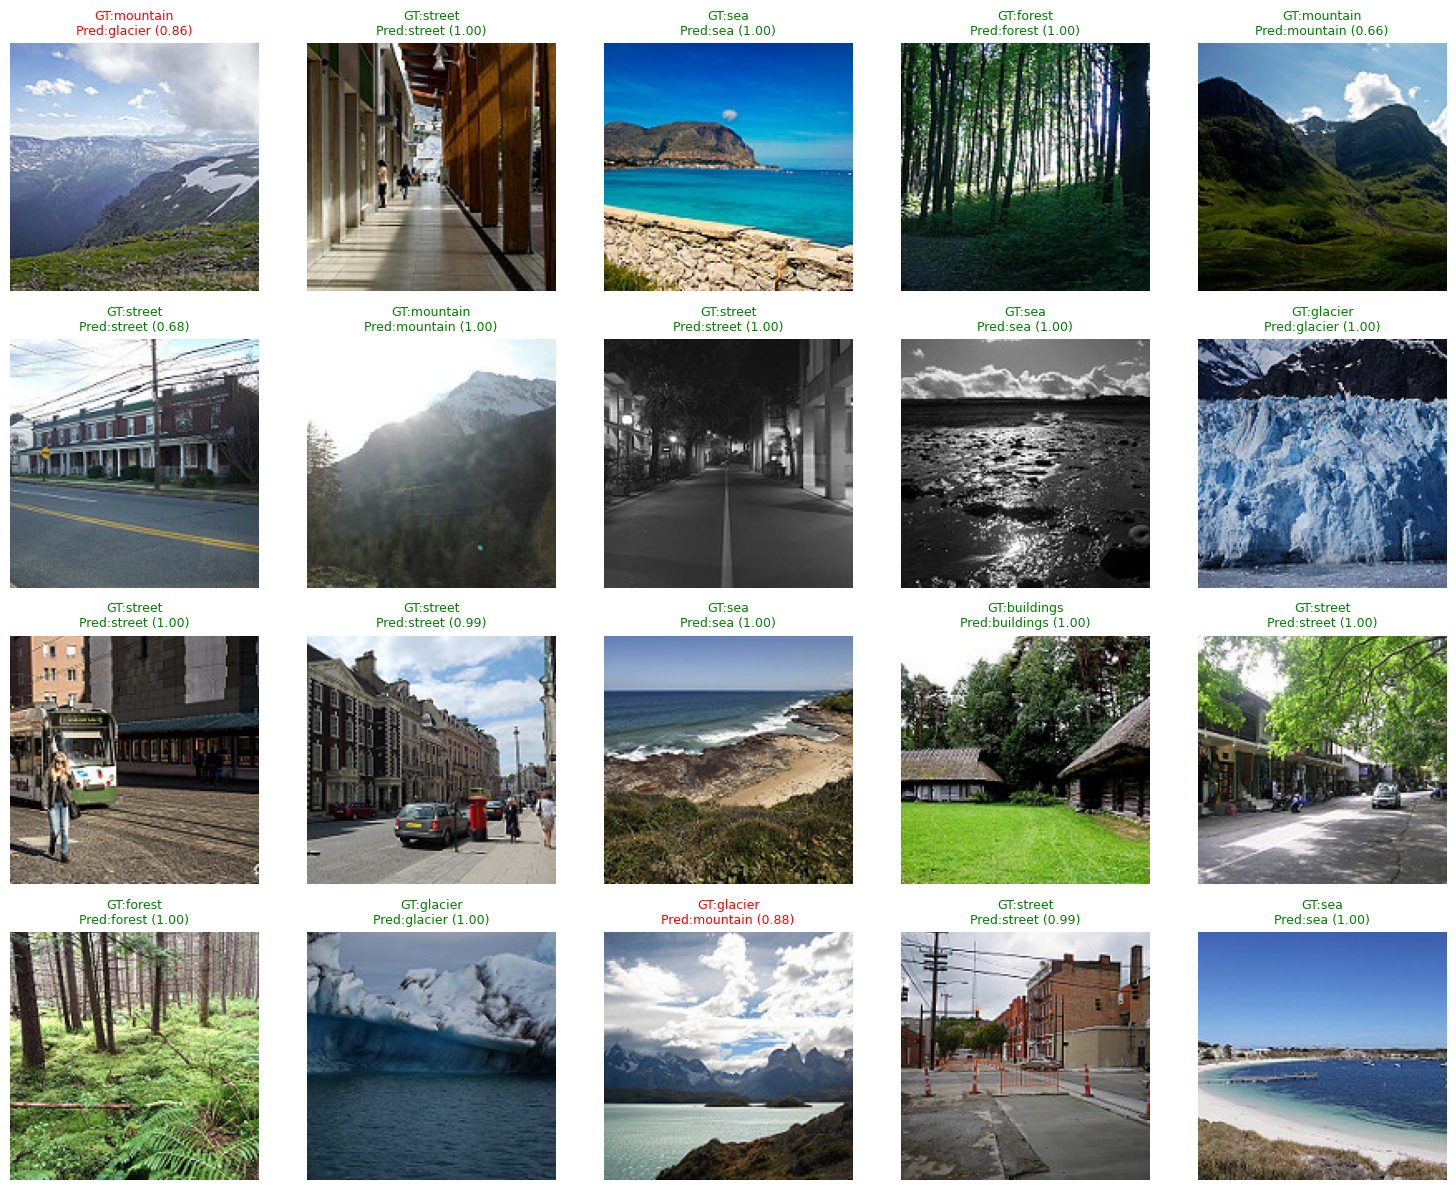

In [72]:
show_pred_gt_grid(results_df)


In [34]:
def show_per_class(df, class_name, k=5):
    subset = df[df.true_label == class_name]

    best = subset[subset.correct].sort_values("pred_conf", ascending=False).head(k)
    worst = subset[~subset.correct].sort_values("pred_conf", ascending=False).head(k)

    fig, axes = plt.subplots(2, k, figsize=(k*3, 6))
    plt.suptitle(f"Class: {class_name}", fontsize=16)

    # BEST
    for ax, row in zip(axes[0], best.itertuples()):
        img = Image.open(row.image_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"Pred:{row.pred_label} ({row.pred_conf:.2f})", color="green")
        ax.axis("off")

    # WORST
    for ax, row in zip(axes[1], worst.itertuples()):
        img = Image.open(row.image_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"Pred:{row.pred_label} ({row.pred_conf:.2f})", color="red")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


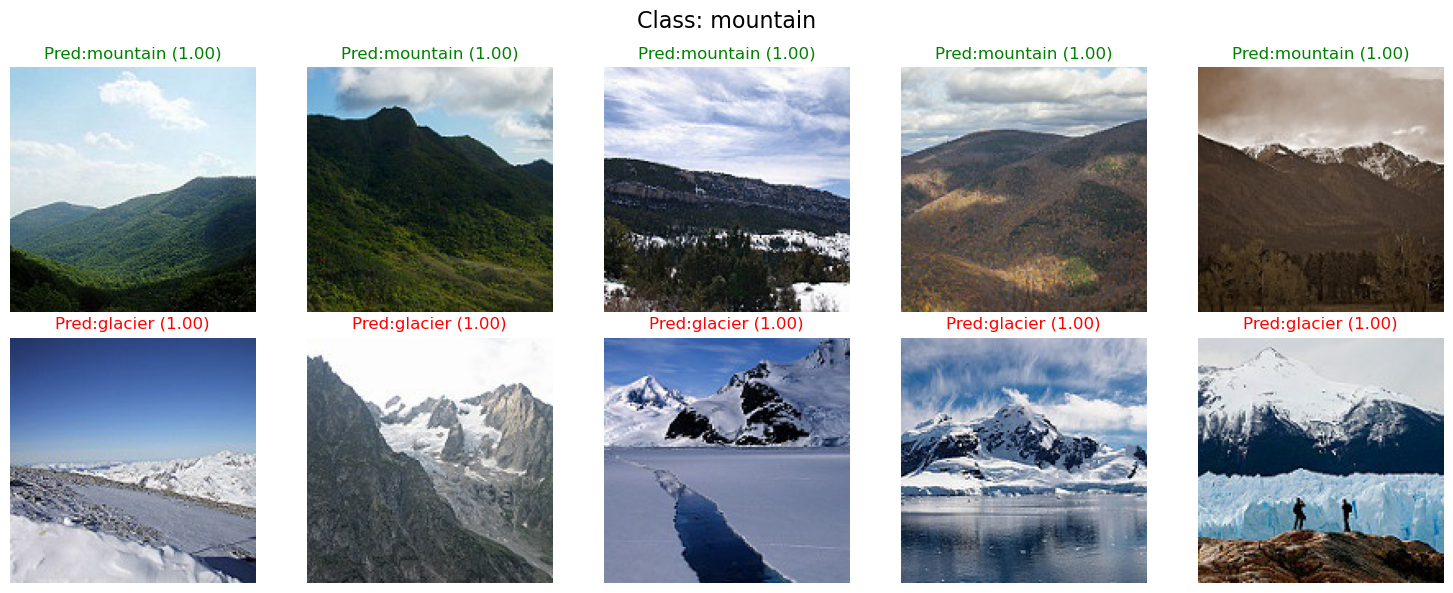

In [73]:
show_per_class(results_df, class_name="mountain", k=5)


In [36]:
def plot_confidence_histogram(df):
    plt.figure(figsize=(8,5))
    plt.hist(df.pred_conf, bins=20, color="skyblue", edgecolor="black")
    plt.title("Prediction Confidence Distribution")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.show()


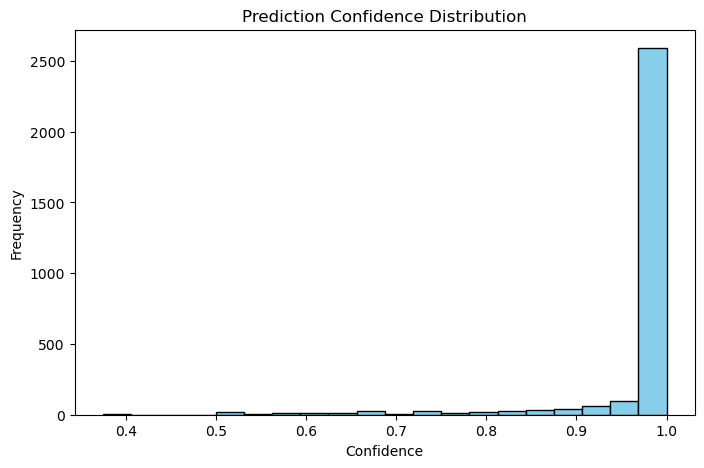

In [37]:
plot_confidence_histogram(results_df)


In [38]:
def plot_confidence_reliability(df):
    bins = np.linspace(0, 1, 11)
    df["conf_bin"] = np.digitize(df.pred_conf, bins) - 1

    acc_per_bin = df.groupby("conf_bin")["correct"].mean()
    conf_per_bin = df.groupby("conf_bin")["pred_conf"].mean()

    plt.figure(figsize=(7,6))
    plt.plot(conf_per_bin, acc_per_bin, marker="o")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Plot (Calibration Curve)")
    plt.show()


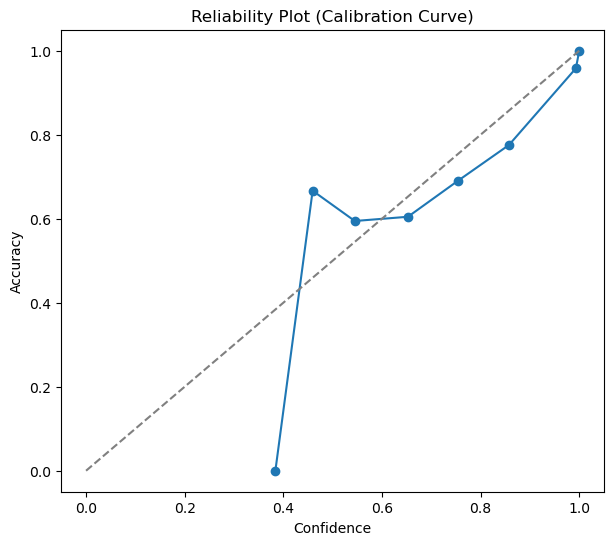

In [74]:
plot_confidence_reliability(results_df)


The reliability curve shows that the model exhibits strong calibration at high-confidence predictions (0.9–1.0). Moderate miscalibration is observed in the 0.6–0.8 confidence range, where accuracy slightly lags behind confidence, indicating mild overconfidence. Low-confidence bins (<0.5) contain few samples, leading to unstable estimates. Overall, the model demonstrates good calibration for practical usage.

In [40]:
def plot_confusion_matrix(df, classes):
    y_true = df.true_idx
    y_pred = df.pred_idx

    cm = confusion_matrix(y_true, y_pred, normalize="true")

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, cmap="mako",
                xticklabels=classes, yticklabels=classes,
                fmt=".2f")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.show()


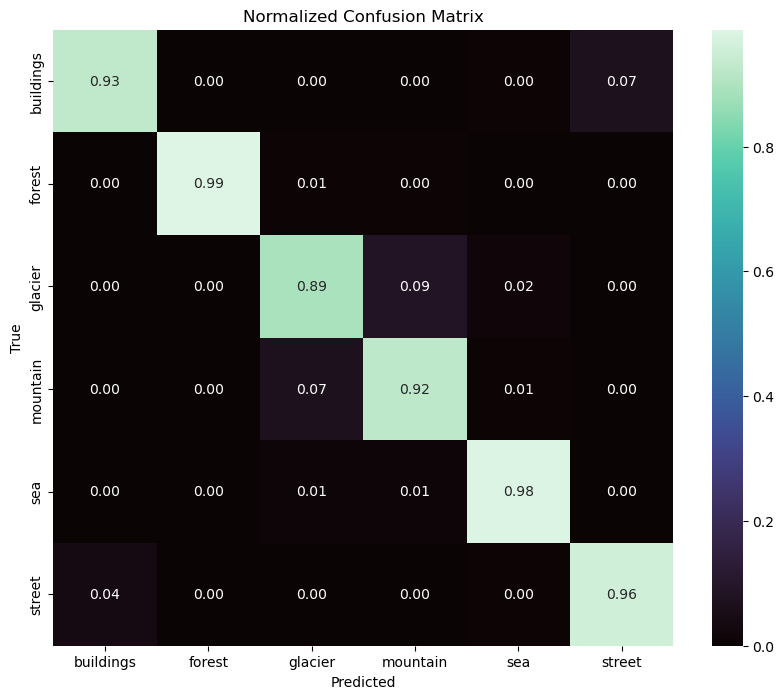

In [41]:
plot_confusion_matrix(results_df, classes)


Text(0.5, 1.0, 'Confidence of Wrong Predictions')

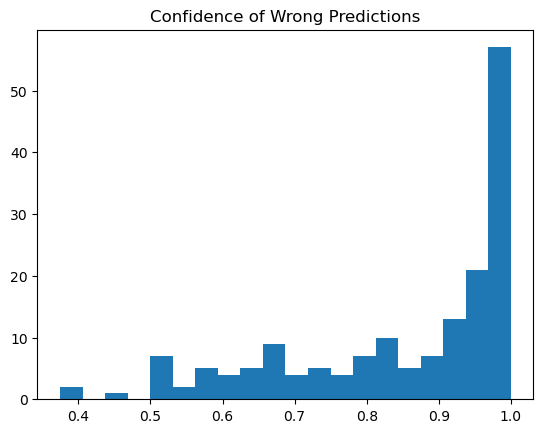

In [75]:
wrong = results_df[results_df["correct"] == False]
plt.hist(wrong.pred_conf, bins=20)
plt.title("Confidence of Wrong Predictions")

In [60]:
import pandas as pd
from PIL import Image

image_paths = []
true_idx_list = []
true_label_list = []
pred_idx_list = []
pred_label_list = []
pred_conf_list = []

model.eval()

with torch.no_grad():
    for path, true_idx in valid_data.samples:
        img = Image.open(path).convert("RGB")
        t = valid_transform(img).unsqueeze(0).to(device)

        logits = model(t)
        probs = torch.softmax(logits, dim=1)

        pred_idx = probs.argmax(1).item()
        pred_conf = probs[0][pred_idx].item()

        image_paths.append(path)
        true_idx_list.append(true_idx)
        true_label_list.append(classes[true_idx])
        pred_idx_list.append(pred_idx)
        pred_label_list.append(classes[pred_idx])
        pred_conf_list.append(pred_conf)


In [ ]:
results_df["correct"] = results_df["true_idx"] == results_df["pred_idx"]
#correct tells us whether each prediction was right or wrong, and without it, 
# we cannot meaningfully visualize or analyze the model’s performance.

In [62]:
results_df = pd.DataFrame({
    "image_path": image_paths,
    "true_idx": true_idx_list,
    "true_label": true_label_list,
    "pred_idx": pred_idx_list,
    "pred_label": pred_label_list,
    "pred_conf": pred_conf_list
})


In [42]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image


In [63]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # FORWARD HOOK
        def forward_hook(module, inp, out):
            self.activations = out

        # BACKWARD HOOK
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()

        outputs = self.model(input_tensor)
        probs = F.softmax(outputs, dim=1)

        if class_idx is None:
            class_idx = probs.argmax(dim=1).item()

        target_score = outputs[:, class_idx]
        target_score.backward()

        # GAP over gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze()

        cam = torch.relu(cam)

        # normalize
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.detach().cpu().numpy()      # FIXED


In [64]:
def overlay_heatmap(img, cam, alpha=0.45):
    cam_resized = cv2.resize(cam, (img.width, img.height))
    cam_uint8 = np.uint8(255 * cam_resized)

    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_np = np.array(img)
    overlay = (1 - alpha) * img_np + alpha * heatmap
    overlay = overlay.astype(np.uint8)

    return overlay


In [65]:
def show_xai_grid(model, df, gradcam, rows=3, cols=4):
    subset = df.sample(rows * cols)

    plt.figure(figsize=(cols * 5, rows * 5))

    for i, row in enumerate(subset.itertuples()):
        img = Image.open(row.image_path).convert("RGB")
        tensor = valid_transform(img).unsqueeze(0).to(device)

        cam = gradcam.generate(tensor, class_idx=row.pred_idx)
        heatmap = overlay_heatmap(img, cam)

        color = "green" if row.correct else "red"
        title = f"GT:{row.true_label} | Pred:{row.pred_label} ({row.pred_conf:.2f})"

        # ORIGINAL
        plt.subplot(rows, cols * 2, i * 2 + 1)
        plt.imshow(img)
        plt.title(title, color=color, fontsize=10)
        plt.axis("off")

        # HEATMAP
        plt.subplot(rows, cols * 2, i * 2 + 2)
        plt.imshow(heatmap)
        plt.title("Grad-CAM Heatmap", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [66]:
target_layer = model.blocks[-1]
gradcam = GradCAM(model, target_layer)


/home/vighnesh/anaconda3/envs/aiwork/lib/python3.13/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


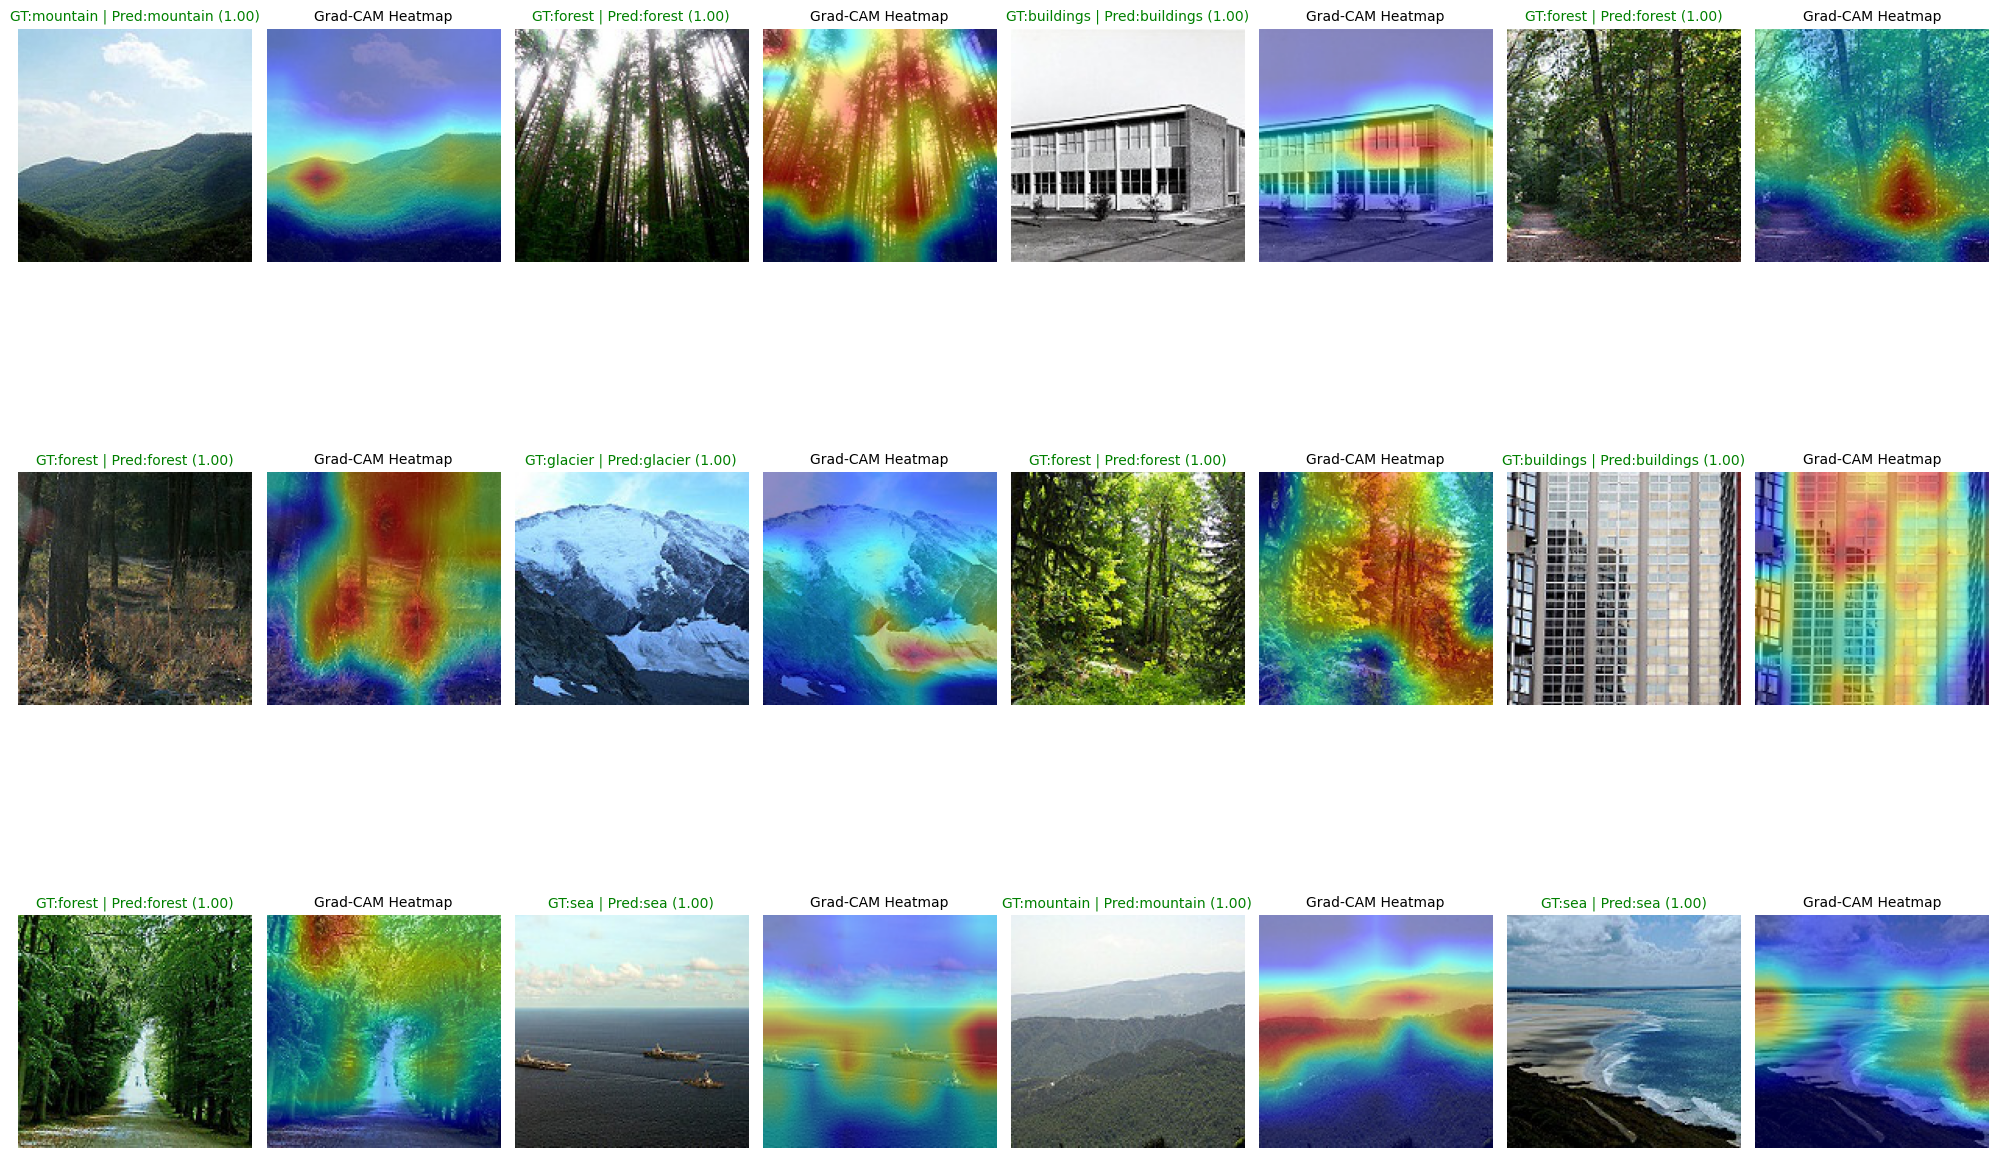

In [85]:
show_xai_grid(model, results_df, gradcam, rows=3, cols=4)


In [59]:
print(results_df.head())
print(results_df.columns)

                                          image_path  true_idx true_label  \
0  archive-intel/seg_test/seg_test/buildings/2005...         0  buildings   
1  archive-intel/seg_test/seg_test/buildings/2006...         0  buildings   
2  archive-intel/seg_test/seg_test/buildings/2006...         0  buildings   
3  archive-intel/seg_test/seg_test/buildings/2006...         0  buildings   
4  archive-intel/seg_test/seg_test/buildings/2007...         0  buildings   

   pred_idx pred_label  pred_conf  conf_bin  
0         0  buildings   0.999998         9  
1         0  buildings   0.992826         9  
2         0  buildings   0.999997         9  
3         0  buildings   1.000000         9  
4         0  buildings   0.999986         9  
Index(['image_path', 'true_idx', 'true_label', 'pred_idx', 'pred_label',
       'pred_conf', 'conf_bin'],
      dtype='object')


In [79]:
def predict_single_image(model, img_path, classes, transform):
    img = Image.open(img_path).convert("RGB")

    x = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, 1)
        pred_idx = probs.argmax(1).item()
        pred_label = classes[pred_idx]
        conf = probs[0][pred_idx].item()

    return pred_label, conf, img


In [80]:
def show_pred_vs_gt(model, img_path, true_label, classes, transform):
    pred_label, conf, img = predict_single_image(
        model, img_path, classes, transform
    )

    correct = (pred_label == true_label)
    color = "green" if correct else "red"

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(
        f"GT: {true_label}\nPred: {pred_label} ({conf*100:.2f}%)",
        color=color,
        fontsize=12
    )
    plt.axis("off")
    plt.show()


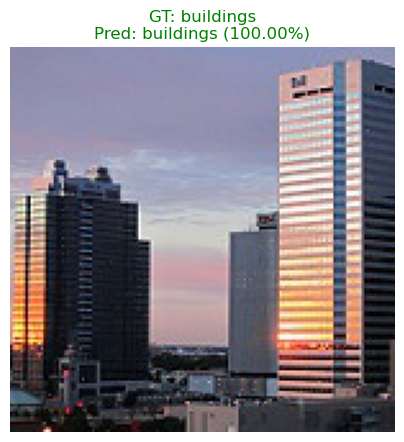

In [84]:
img_path = "archive-intel/seg_pred/seg_pred/5.jpg"
true_label = "buildings"   # your ground truth

show_pred_vs_gt(
    model=model,
    img_path=img_path,
    true_label=true_label,
    classes=classes,
    transform=valid_transform
)


In [86]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        
        self.gradients = None
        self.activations = None
        
        def forward_hook(module, inp, out):
            self.activations = out

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        
        probs = F.softmax(output, dim=1)
        if class_idx is None:
            class_idx = probs.argmax(1).item()
        
        target = output[:, class_idx]
        target.backward()

        # GAP over gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze()
        cam = torch.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.detach().cpu().numpy()


In [87]:
def overlay_heatmap(img, cam, alpha=0.45):
    cam = cv2.resize(cam, (img.width, img.height))
    cam = np.uint8(255 * cam)

    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_np = np.array(img)
    overlay = (1 - alpha) * img_np + alpha * heatmap
    return overlay.astype(np.uint8)


In [88]:
def predict_single(model, img_path, classes, transform):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)

    pred_idx = probs.argmax(1).item()
    pred_label = classes[pred_idx]
    conf = probs[0][pred_idx].item()

    return pred_label, pred_idx, conf, img, x


In [89]:
def show_xai_single_image(model, img_path, true_label, classes, transform, gradcam):
    pred_label, pred_idx, conf, img, x = predict_single(model, img_path, classes, transform)

    # Generate Grad-CAM
    cam = gradcam.generate(x, pred_idx)
    heatmap = overlay_heatmap(img, cam)

    # correct/incorrect color
    correct = (pred_label == true_label)
    color = "green" if correct else "red"

    plt.figure(figsize=(10,5))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original\nGT: {true_label}", fontsize=11)
    plt.axis("off")

    # Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title(
        f"Pred: {pred_label} ({conf*100:.1f}%)",
        color=color,
        fontsize=11
    )
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [90]:
target_layer = model.blocks[-1]
gradcam = GradCAM(model, target_layer)


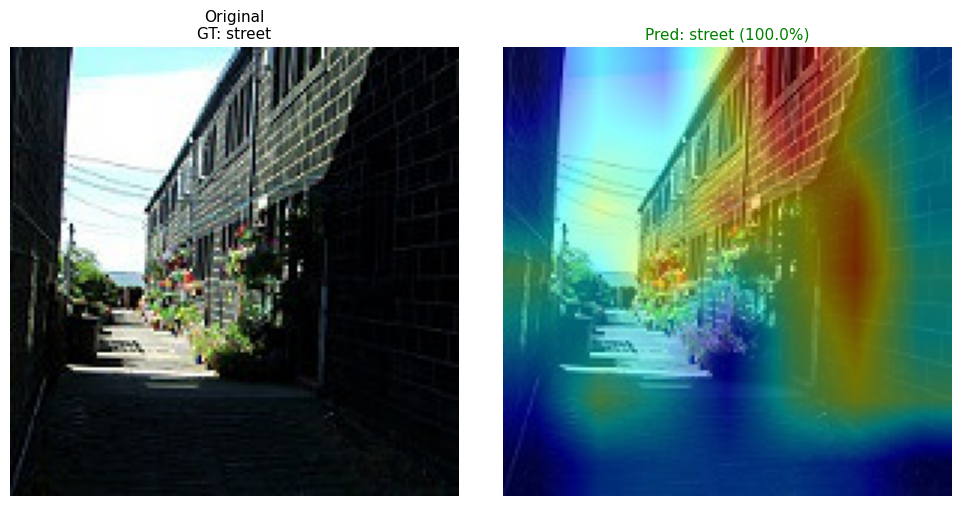

In [94]:
img_path = "archive-intel/seg_test/seg_test/street/20079.jpg"
true_label = "street"    # <-- your actual GT

show_xai_single_image(
    model,
    img_path,
    true_label,
    classes,
    valid_transform,
    gradcam
)
